# Installation and Repository cloning

In [42]:
#!pip install adversarial-robustness-toolbox -U
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install git+https://github.com/RobustBench/robustbench.git
#!pip install matplotlib
#!pip install pillow
#!pip install foolbox

## Import Libraries

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
import json
import foolbox as fb

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Prepare CIFAR-10 Dataset

In [45]:
def load_dataset(dataset_split):
    # Load CIFAR-10 dataset using torchvision
    transform = transforms.Compose([
      transforms.ToTensor(),
                                 ])
    testset = datasets.CIFAR10(root='./data/cifar', train=False, download=True, transform=transform)

    # Truncated testset for experiments and ablations
    if isinstance(dataset_split, int):
        testset, _ = torch.utils.data.random_split(testset,
                                                          [dataset_split, len(testset) - dataset_split],
                                                          generator=torch.Generator().manual_seed(42))
    
    # Extract data and labels from torchvision dataset
    xtest = torch.stack([data[0] for data in testset])
    ytest = torch.tensor([data[1] for data in testset])

    return xtest, ytest

## Load and Prepare Adversarial Model

In [46]:
from robustbench.utils import load_model

model_name = 'Sehwag2021Proxy_R18'
net = load_model(model_name=model_name, dataset='cifar10', threat_model='L2')
net = torch.nn.DataParallel(net)

net.eval()
net.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Initialize PyTorchClassifier for ART toolbox as a wrapper
art_net = PyTorchClassifier(model=net,
                               loss=criterion,
                               optimizer=optimizer,
                               input_shape=(3, 32, 32),
                               nb_classes=10,
                               device_type=device,
                               clip_values=(0.0, 1.0))
fb_net = fb.PyTorchModel(net, bounds=(0.0, 1.0), device=device)

## Function to Test Model Accuracy

In [47]:
def test_accuracy(model, xtest, ytest):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for i in range(len(xtest)):
            x = xtest[i].unsqueeze(0).to(device)
            y = ytest[i].unsqueeze(0).to(device)

            outputs = model(x)
            _, predicted = torch.max(outputs, 1)

            total += y.size(0)
            correct += (predicted==y).sum().item()

    accuracy = (correct / total) * 100
    print(f'\nAccuracy of the testset is: {accuracy:.3f}%\n')

## Adversarial Attacks

In [48]:
from art.attacks.evasion import (FastGradientMethod,
                                 ProjectedGradientDescentPyTorch,
                                 AutoProjectedGradientDescent,
                                 AutoAttack,
                                 CarliniL2Method,
                                 DeepFool,
                                 ElasticNet)
from adversarial_attack.exp_attack import ExpAttack
from adversarial_attack.acc_exp_attack import AccExpAttack
from adversarial_attack.exp_attack_l1 import ExpAttackL1
from autoattack import AutoAttack as original_AutoAttack

In [49]:
class AdversarialAttacks:
  def __init__(self, art_net, net, epsilon, eps_iter, norm, max_iterations_fast_attacks, max_iterations_slow_attacks):
    self.art_net = art_net
    self.epsilon = epsilon
    self.eps_iter = eps_iter
    self.norm = norm
    self.max_iterations_fast_attacks = max_iterations_fast_attacks
    self.max_iterations_slow_attacks = max_iterations_slow_attacks
    self.net = net
  def init_attacker(self, attack_type, **kwargs):
    if attack_type=='fast_gradient_method':
        return FastGradientMethod(self.art_net,
                                eps=self.epsilon,
                                eps_step=self.epsilon,
                                norm=self.norm,
                                **kwargs)
    elif attack_type=='projected_gradient_descent':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=self.max_iterations_fast_attacks,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='pgd_early_stopping':
        return ProjectedGradientDescentPyTorch(self.art_net,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=1,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='ART_AutoAttack':
        return AutoAttack(estimator=self.art_net,
                        eps=self.epsilon,
                        eps_step=self.eps_iter,
                        norm=self.norm)
    elif attack_type=='original_AutoAttack':
        return original_AutoAttack(net, 
                                   norm='L1', 
                                   eps=self.epsilon,
                                   device=device)
    elif attack_type=='auto_projected_gradient_descent':
        return AutoProjectedGradientDescent(estimator=self.art_net,
                                          eps=self.epsilon,
                                          eps_step=self.eps_iter,
                                          norm=self.norm,
                                          max_iter=self.max_iterations_fast_attacks,
                                          **kwargs)
    elif attack_type=='brendel_bethge':
        return fb.attacks.L1BrendelBethgeAttack(steps=self.max_iterations_fast_attacks)
    elif attack_type=='carlini_wagner_l2':
        return CarliniL2Method(self.art_net,
                               max_iter=self.max_iterations_slow_attacks,
                               **kwargs)
    elif attack_type=='deep_fool':
        return DeepFool(self.art_net,
                      max_iter=self.max_iterations_fast_attacks,
                      epsilon=self.eps_iter,
                      **kwargs)
    elif attack_type=='elastic_net':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,learning_rate=0.01)
    elif attack_type=='elastic_net_L1_rule':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1')
    elif attack_type=='elastic_net_L1_rule_higher_beta':
        return ElasticNet(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,
                      decision_rule='L1',
                      beta=0.01)
    elif attack_type=='exp_attack':
        return ExpAttack(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,learning_rate=1)
    elif attack_type=='exp_attack_smooth':
        return ExpAttack(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,learning_rate=1,smooth=True)
    elif attack_type=='exp_attack_l1':
        return ExpAttackL1(self.art_net,
                      max_iter=self.max_iterations_slow_attacks,learning_rate=1)
    else:
        raise ValueError(f'Attack type "{attack_type}" not supported!')

## Plug-in Function for Adversarial Attack with Early Stopping

In [50]:
def attack_with_early_stopping(art_net, x, y, PGD_iterations, attacker):
    label_flipped = False

    for j in range(PGD_iterations):
        adv_inputs = attacker.generate(x, y.numpy(), verbose=False)

        outputs = art_net.predict(adv_inputs)
        _, predicted = torch.max(torch.tensor(outputs).data, 1)
        label_flipped = bool(predicted.item() != int(y.item()))

        if label_flipped:
            print(f'\tIterations for successful iterative attack: {j+1}')
            break
        
        x = adv_inputs.copy()
            
    return adv_inputs

## Function for Adversarial Distance calculation (attack methods)

In [51]:
def calculation(art_net, fb_net, net, xtest, ytest, epsilon, eps_iter, norm, max_iterations_slow_attacks, max_iterations_fast_attacks, attack_type, verbose: bool = False):

    distance_list, runtime_list = [], []
    art_net.model.to(device)
    net.to(device)
    
    xtest = xtest.to(device)
    ytest = ytest.to(device)
    
    attacks = AdversarialAttacks(art_net=art_net,
                                 net = net,
                          epsilon=epsilon,
                          eps_iter=eps_iter,
                          norm=norm,
                          max_iterations_fast_attacks=max_iterations_fast_attacks,
                          max_iterations_slow_attacks=max_iterations_slow_attacks)
    attacker = attacks.init_attacker(attack_type)

    robust_predictions = 0
    attack_successes = 0
    clean_correct = 0

    for i, x in enumerate(xtest):

        x = x.unsqueeze(0)
        y = ytest[i].unsqueeze(0)
        outputs = art_net.predict(x.cpu())
        
        _, clean_predicted = torch.max(torch.tensor(outputs).data, 1)
            
        if int(clean_predicted.item()) != int(y.item()):
            print('Misclassified input. Not attacking.')
            distance_list.append(False)
            runtime_list.append(False)
            continue        

        clean_correct += 1

        start_time = time.time()

        if attack_type == 'pgd_early_stopping':
            x_adversarial = attack_with_early_stopping(art_net=art_net,
                                                                x=x.numpy(),
                                                                y=y,
                                                                PGD_iterations=max_iterations_fast_attacks,
                                                                attacker=attacker)
            x_adversarial = torch.from_numpy(x_adversarial)
        elif attack_type == 'brendel_bethge':
            _, x_adversarial, _ = attacker(fb_net, x, y, epsilons=[epsilon])
            x_adversarial = x_adversarial[0]
        elif attack_type == 'original_AutoAttack':
            x_adversarial = attacker.run_standard_evaluation(x, y)
            x_adversarial = x_adversarial
        else:             
            x_adversarial = attacker.generate(x.cpu().numpy(), y.cpu().numpy())
            x_adversarial = torch.from_numpy(x_adversarial)
        
        end_time = time.time()
        runtime = end_time - start_time
        runtime_list.append(runtime)

        # Adversarial accuracy calculation
        output_adversarial = art_net.predict(x_adversarial)
        _, predicted_adversarial = torch.max(torch.tensor(output_adversarial).data, 1)

        # Adversarial distance calculation: if no AE found, save epsilon as distance, otherwise save the distance
        if int(predicted_adversarial.item()) == int(y.item()):
            robust_predictions += 1
            distance = epsilon
            distance_list.append(distance)
            if verbose:
                print(f'Image {i}: No adversarial example found.')
        else:
            distance = torch.norm((x.cpu() - x_adversarial), p=float(norm))
            robust_predictions += (round(distance.item(), 2) > epsilon) 
            attack_successes += (round(distance.item(), 2) <= epsilon) 
            distance_list.append(min(distance.item(), epsilon)) #appending epsilon if distance of adversarial example is higher

        if verbose:
            print(f'Image {i}\t\tAdversarial_distance: {distance:.5f}\t\tRuntime: {runtime:5f} seconds')
        if (i + 1) % 20 == 0:
            print(f'{i+1} images done. Current Adversarial Accuracy: {robust_predictions/(i+1)}%')

    adversarial_accuracy = (robust_predictions / len(xtest)) * 100
    attack_success_rate = (attack_successes / clean_correct) * 100
    print(f'\nAdversarial accuracy: {adversarial_accuracy}%\n')

    return distance_list, runtime_list, adversarial_accuracy, attack_success_rate

## Parameters

In [52]:
norm = 1  # 1, 2, np.inf
max_iterations_fast_attacks = 100
max_iterations_slow_attacks = 100
eps_iter = 0.15
epsilon = 12

## Load the dataset

In [53]:
splitsize = 50      # full, int: splitsize
xtest, ytest = load_dataset(dataset_split=splitsize)

Files already downloaded and verified


## Test Accuracy

In [54]:
test_accuracy(net, xtest, ytest)


Accuracy of the testset is: 92.000%



# Experiments

In [55]:
attack_types = [#'fast_gradient_method', #bounded-full
                #'projected_gradient_descent', #bounded-full
                #'pgd_early_stopping', #not-bounded
                #'auto_projected_gradient_descent', #bounded-full
                #'deep_fool', #not-bounded
                #'brendel_bethge', #bounded-min
                #'carlini_wagner_l2', #not-bounded
                #'elastic_net', #not-bounded
                #'exp_attack',
                #'exp_attack_smooth',
                'exp_attack_l1',
                #'elastic_net_L1_rule', #not-bounded
                #'elastic_net_L1_rule_higher_beta', #not-bounded
                #'ART_AutoAttack', #bounded-full
                #'original_AutoAttack', #bounded-full
                ]

results_dict = {}

for attack_type in attack_types:
    results_dict[attack_type] = {}
    print(f'\t\t-------------------------- Processing Attack: {attack_type} --------------------------\n')
    results_dict[attack_type]["adversarial_distance"], results_dict[attack_type]["runtime"], results_dict[attack_type]["adversarial_accuracy"] , results_dict[attack_type]["attack_success_rate"] = calculation(
                                                        art_net=art_net,
                                                        fb_net=fb_net,
                                                        net = net,
                                                        xtest=xtest,
                                                        ytest=ytest,
                                                        epsilon=epsilon,
                                                        eps_iter=eps_iter,
                                                        norm=norm,
                                                        max_iterations_fast_attacks=max_iterations_fast_attacks,
                                                        max_iterations_slow_attacks=max_iterations_slow_attacks,
                                                        attack_type=attack_type,
                                                        verbose=True)
    
    mean_value = np.mean([x for x in results_dict[attack_type]["adversarial_distance"] if x is not None])

    print(f'\nMean adversarial distance for {attack_type}: {mean_value:.5f} with total runtime: {sum(results_dict[attack_type]["runtime"]): .5f} seconds\n')

		-------------------------- Processing Attack: exp_attack_l1 --------------------------



ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 0		Adversarial_distance: 11.99999		Runtime: 1.274946 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 1		Adversarial_distance: 12.00000		Runtime: 1.283263 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 2: No adversarial example found.
Image 2		Adversarial_distance: 12.00000		Runtime: 1.328430 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 3		Adversarial_distance: 9.64017		Runtime: 1.251595 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 4		Adversarial_distance: 0.58049		Runtime: 1.261849 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 5		Adversarial_distance: 12.00000		Runtime: 1.250733 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 6: No adversarial example found.
Image 6		Adversarial_distance: 12.00000		Runtime: 1.306957 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 7: No adversarial example found.
Image 7		Adversarial_distance: 12.00000		Runtime: 1.342793 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 8		Adversarial_distance: 8.32108		Runtime: 1.305613 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 9		Adversarial_distance: 4.92001		Runtime: 1.325784 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 10: No adversarial example found.
Image 10		Adversarial_distance: 12.00000		Runtime: 1.339562 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 11: No adversarial example found.
Image 11		Adversarial_distance: 12.00000		Runtime: 1.304633 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 12: No adversarial example found.
Image 12		Adversarial_distance: 12.00000		Runtime: 1.297196 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 13		Adversarial_distance: 11.69113		Runtime: 1.304169 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 14: No adversarial example found.
Image 14		Adversarial_distance: 12.00000		Runtime: 1.278133 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 15		Adversarial_distance: 12.00001		Runtime: 1.277169 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 16		Adversarial_distance: 1.30409		Runtime: 1.288131 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 17: No adversarial example found.
Image 17		Adversarial_distance: 12.00000		Runtime: 1.281261 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 18		Adversarial_distance: 12.00002		Runtime: 1.262638 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 19: No adversarial example found.
Image 19		Adversarial_distance: 12.00000		Runtime: 1.422064 seconds
20 images done. Current Adversarial Accuracy: 0.45%


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 20: No adversarial example found.
Image 20		Adversarial_distance: 12.00000		Runtime: 1.305786 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 21: No adversarial example found.
Image 21		Adversarial_distance: 12.00000		Runtime: 1.304452 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 22: No adversarial example found.
Image 22		Adversarial_distance: 12.00000		Runtime: 1.312828 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 23: No adversarial example found.
Image 23		Adversarial_distance: 12.00000		Runtime: 1.329020 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 24		Adversarial_distance: 12.00000		Runtime: 1.300360 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 25: No adversarial example found.
Image 25		Adversarial_distance: 12.00000		Runtime: 1.310035 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 26: No adversarial example found.
Image 26		Adversarial_distance: 12.00000		Runtime: 1.322620 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 27: No adversarial example found.
Image 27		Adversarial_distance: 12.00000		Runtime: 1.300242 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 28		Adversarial_distance: 12.00000		Runtime: 1.296486 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 29		Adversarial_distance: 12.00001		Runtime: 1.269604 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 30: No adversarial example found.
Image 30		Adversarial_distance: 12.00000		Runtime: 1.280878 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 31		Adversarial_distance: 12.00000		Runtime: 1.301188 seconds
Misclassified input. Not attacking.


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 33: No adversarial example found.
Image 33		Adversarial_distance: 12.00000		Runtime: 1.307794 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 34: No adversarial example found.
Image 34		Adversarial_distance: 12.00000		Runtime: 1.299758 seconds
Misclassified input. Not attacking.


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 36: No adversarial example found.
Image 36		Adversarial_distance: 12.00000		Runtime: 1.307150 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 37: No adversarial example found.
Image 37		Adversarial_distance: 12.00000		Runtime: 1.285159 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 38		Adversarial_distance: 1.62524		Runtime: 1.248651 seconds
Misclassified input. Not attacking.


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 40		Adversarial_distance: 11.99999		Runtime: 1.266565 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 41		Adversarial_distance: 12.00001		Runtime: 1.265849 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 42		Adversarial_distance: 4.72460		Runtime: 1.274822 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 43: No adversarial example found.
Image 43		Adversarial_distance: 12.00000		Runtime: 1.283679 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 44		Adversarial_distance: 8.96017		Runtime: 1.276891 seconds
Misclassified input. Not attacking.


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 46: No adversarial example found.
Image 46		Adversarial_distance: 12.00000		Runtime: 1.285722 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 47		Adversarial_distance: 12.00000		Runtime: 1.296580 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 48: No adversarial example found.
Image 48		Adversarial_distance: 12.00000		Runtime: 1.296863 seconds


ExpAttackL1:   0%|          | 0/1 [00:00<?, ?it/s]

Image 49: No adversarial example found.
Image 49		Adversarial_distance: 12.00000		Runtime: 1.290859 seconds

Adversarial accuracy: 50.0%


Mean adversarial distance for exp_attack_l1: 9.91534 with total runtime:  59.60676 seconds



## Save Results to JSON File

In [56]:
json_file_path = f'./data/attack_comparison_{model_name}_L{norm}.json'

with open(json_file_path, 'w') as f:
    json.dump(results_dict, f, indent=4)
print(f'Evaluation results are saved under "{json_file_path}".')

Evaluation results are saved under "./data/attack_comparison_Sehwag2021Proxy_R18_L1.json".


# Plotting

## Distances

/tmp/ipykernel_50258/2966780136.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


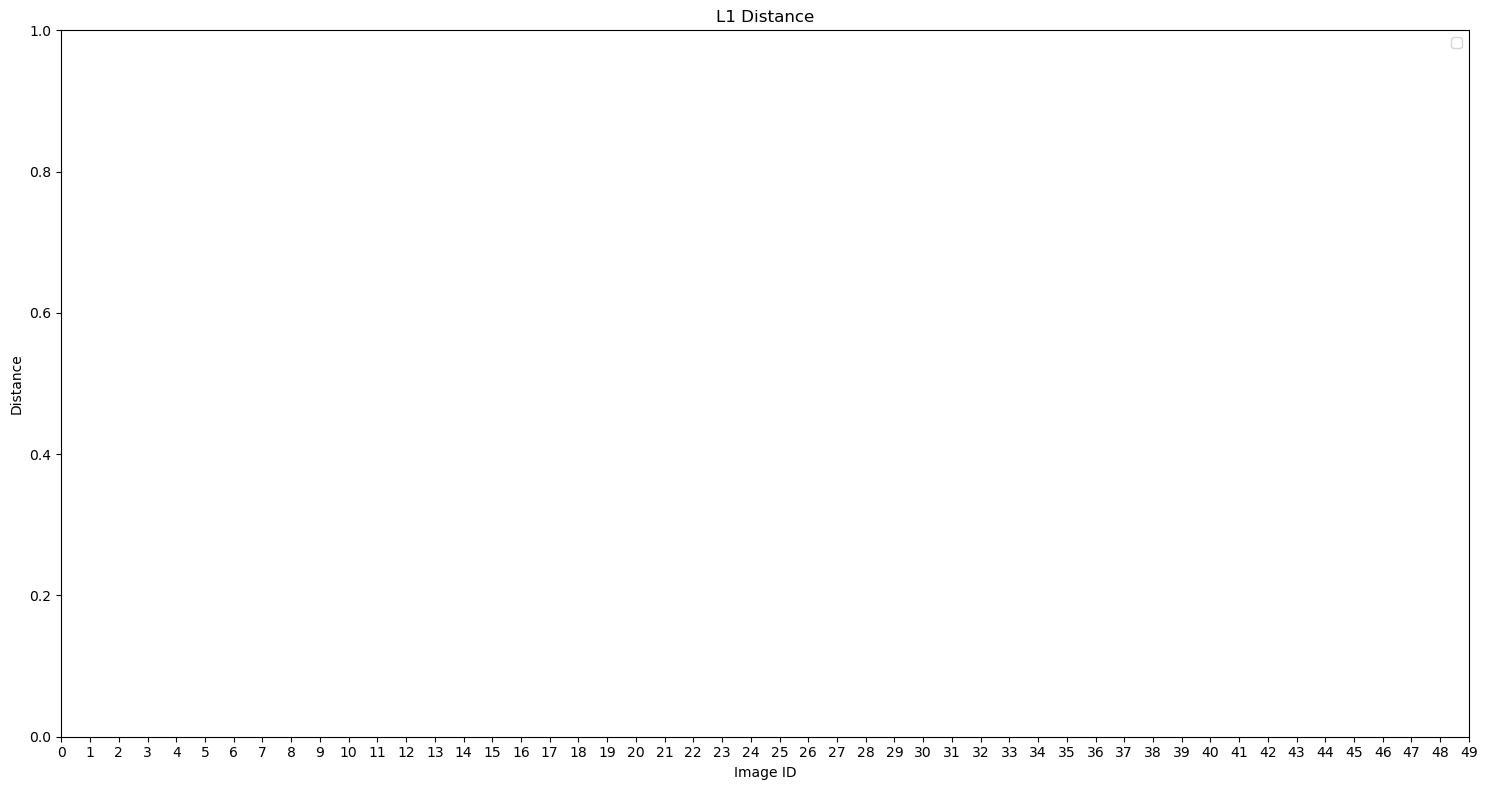

In [ ]:
attack_types_with_distance = [
                'brendel_bethge', #bounded-min
                'pgd_early_stopping', #not-bounded
                'deep_fool', #not-bounded
                'carlini_wagner_l2', #not-bounded
                'elastic_net', #not-bounded
                'elastic_net_L1_rule', #not-bounded
                'elastic_net_L1_rule_higher_beta', #not-bounded
                'exp_attack', #not-bounded
                'exp_attack_1', #not-bounded
                'exp_attack_smooth', #not-bounded
                ]

selected_attack_types_with_distance = [a for a in attack_types if a in attack_types_with_distance]

plt.figure(figsize=(15, 8))
for attack_type in selected_attack_types_with_distance:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Distance')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

# Runtime per image

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['runtime'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Runtime [seconds]')
plt.title('Runtime per image')
plt.legend()
plt.tight_layout()
plt.show()

## Adversarial Accuracy

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['adversarial_accuracy'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Adversarial accuracy [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Adversarial Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['attack_success_rate'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Attack Success Rate [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Attack Success Rate')
plt.tight_layout()
plt.show()

## Total Runtime

In [ ]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, sum(results_dict[attack_type]['runtime'])/splitsize, label=attack_type)
plt.xlabel('Attacks')
plt.xticks(rotation=45)
plt.ylabel('Runtime [seconds]')
plt.title('Average Runtime per Image')
plt.legend()
plt.tight_layout()
plt.show()